In [137]:
import pandas as pd
import src.scrape_insta
import src.clean as clean
%autoreload
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.model_selection import cross_val_score


In [2]:
qualdf = pd.read_csv('soft_content.txt', sep="|")

In [3]:
urls = list(qualdf.url.unique())
pickle_in2 = open("quant_data.pkl","rb")
quant_df = pickle.load(pickle_in2)

In [ ]:
def standard_url(thing):
    thing = re.sub('https', 'http', thing)
    matches = re.findall('http.+?taken',str(thing))
    return matches[0]     

In [107]:
quant_df['url'] = quant_df['url'].apply(standard_url)
qualdf['url'] = qualdf['url'].apply(standard_url)
quant_url_index = quant_df.set_index('url', drop=False)
qual_url_index = qualdf.set_index('url')
combined = pd.concat([quant_url_index, qual_url_index], axis=1, join_axes=[qual_url_index.index])

In [138]:
combined2= clean.clean_combined(combined)

In [117]:
def make_hashtag_tfidf(combined_df):
    hashtag_corpus = list(combined_df.hashtags)
    hashtag_corpus2 = take_out_sign(hashtag_corpus)
    hashtag_corpus3=[' '.join(hashtag_corpus2[i]) for i in range(len(hashtag_corpus2))]
    tfidf_hash = TfidfVectorizer(input='content')
    tfidf_hash.fit(hashtag_corpus3)
    hash_mat =tfidf_hash.transform(hashtag_corpus3)
    tfidf_hash_mat = pd.SparseDataFrame(hash_mat, index = combined_df.index).to_dense().fillna(0)
    return tfidf_hash_mat

def take_out_sign(hashtag_corpus, sign='\#'):
    new_corp=[]
    for tags in hashtag_corpus:
        just_words = []
        for tag in tags:
            just_words.append(re.sub(sign,'',tag))
        new_corp.append(just_words)
    return new_corp 


In [118]:
hashtag_tfidf = make_hashtag_tfidf(combined)

In [139]:
combined3 = pd.concat([combined2, hashtag_tfidf], axis=1)

In [482]:
pickle_out = open("hashtags_quant_qual_2017_on.pkl","wb")
pickle.dump(combined3, pickle_out)
pickle_out.close()

In [140]:
y = combined3['number_of_likes']
X = combined3.drop(['number_of_likes'], axis=1)

In [ ]:
gbr = GradientBoostingRegressor(learning_rate=0.01, loss='ls',
                                min_samples_split=4, n_estimators=600,
                                max_depth=2)

In [141]:
scores = cross_val_score(gbr, X, y,cv=40, scoring= 'neg_mean_absolute_error')
print(scores.mean())
print(scores)

-48.32650195367298
[-59.82351088 -26.79792517 -38.82148381 -56.78701579 -29.02385351
 -45.6659021  -79.10286656 -78.27643562 -66.33822741 -33.7705199
 -62.25546547 -46.67703938 -27.34032717 -41.54347126 -54.73353018
 -58.65895547 -45.55458932 -68.56957308 -65.40635927 -87.57694316
 -63.28730687 -58.03115975 -32.47105586 -24.2059365  -37.67969389
 -62.52868588 -54.66668763 -22.06287237 -43.08262548 -32.48622174
 -22.96041188 -26.93641515 -57.52880415 -28.49254001 -47.09419129
 -28.75812841 -30.18536826 -37.30651891 -92.73716857 -57.83429104]


In [149]:
_= gbr.fit(X.as_matrix(), y.as_matrix())
for name, imp in zip(X.columns, gbr.feature_importances_):
    if imp > .015:
        print("{} : {}".format(name, round(imp,3)))

hour : 0.084
month : 0.105
num_people_tagged : 0.031
female : 0.016
no_product : 0.038
61 : 0.034
73 : 0.025
81 : 0.016
106 : 0.028
125 : 0.016
135 : 0.02
154 : 0.039
158 : 0.019
162 : 0.021
163 : 0.068
168 : 0.018
172 : 0.024
193 : 0.027
195 : 0.026
298 : 0.024
300 : 0.038
301 : 0.026
319 : 0.016
321 : 0.015


# Visualizing


In [154]:
past_yr = quant_df[quant_df['date_num']>= 20170000]
used_in_model = quant_df[(quant_df['date_num']>= 20170430)]
just_2017 = quant_df[(quant_df['date_num']>= 20170000) & (quant_df['date_num']< 20180000)]

In [30]:
print(past_yr.number_of_likes.mean())
print(past_yr.number_of_likes.std())
print(2017)
print(just_2017.number_of_likes.mean())
print(just_2017.number_of_likes.std())

275.72222222222223
74.42913264888243
2017
275.2490118577075
75.02891802955955


In [31]:
print(len(just_2017))
print(len(past_yr))

253
270


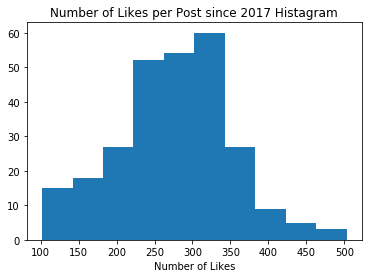

In [165]:
fig, ax = plt.subplots()
_=ax.hist(past_yr.number_of_likes)
_=ax.set_title('Number of Likes per Post since 2017 Histagram')
_=ax.set_xlabel('Number of Likes')

#_=ax.axvline(x=275, ymax=60, ymin=0,color='r')

In [153]:
list(combined3.index)[-1]

'http://www.instagram.com/p/BThF546l0hf/?taken'

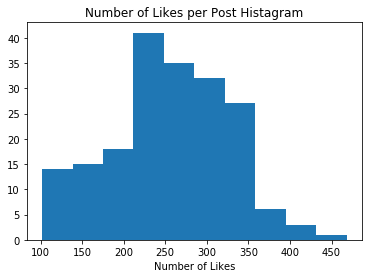

In [163]:
fig, ax = plt.subplots()
_=ax.hist(used_in_model.number_of_likes)
_=ax.set_title('Number of Likes per Post Histagram')
_=ax.set_xlabel('Number of Likes')
#_=ax.axvline(x=275, ymax=60, ymin=0,color='r')

In [157]:
print(past_yr.number_of_likes.mean())
print(past_yr.number_of_likes.std())
print('2017- present')

275.72222222222223
74.42913264888242
2017- present


In [161]:
print("Mean Number of Likes = {}".format(round(used_in_model.number_of_likes.mean(), 2)))
print("Standard Deviation of Likes = {}".format(round(used_in_model.number_of_likes.std(),2)))


Mean Number of Likes = 256.89
Standard Deviation of Likes = 70.37


In [166]:
from sklearn.cluster import KMeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [261]:
qualitative = X[['num_people_tagged','faces_visible','sale','edited', 'butt_pic', 'ocean', 'skate',
 'drift_content', 'product_shot', 'lifestyle', 'in_shop', 'pro\\model', 'in_nature', 'surf',
 'male', 'female', 'mixed_gender', 'bikini', 'apparel', 'biki+apparel', 'no_product']]

In [ ]:
hashtag_tfidf

In [289]:
from sklearn import preprocessing

In [291]:
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(qualitative)

In [467]:
for center in list(list(kmeans.cluster_centers_)):
    index = np.argmax(center)
    print(qualitative[index])
    


KeyError: 17

In [415]:
scaled

array([[ 0.06056714, -0.6336086 , -0.16351749, ..., -1.07578035,
        -0.25819889, -0.41319694],
       [ 1.22345625, -0.6336086 , -0.16351749, ...,  0.92955778,
        -0.25819889, -0.41319694],
       [ 0.06056714, -0.6336086 , -0.16351749, ..., -1.07578035,
        -0.25819889,  2.42015348],
       ...,
       [ 0.06056714,  1.57826141, -0.16351749, ...,  0.92955778,
        -0.25819889, -0.41319694],
       [ 0.06056714,  1.57826141, -0.16351749, ..., -1.07578035,
         3.87298335, -0.41319694],
       [ 0.06056714, -0.6336086 , -0.16351749, ..., -1.07578035,
        -0.25819889,  2.42015348]])

In [381]:
qualitative.drop()

Index(['num_people_tagged', 'faces_visible', 'sale', 'edited', 'butt_pic',
       'ocean', 'skate', 'drift_content', 'product_shot', 'lifestyle',
       'in_shop', 'pro\model', 'in_nature', 'surf', 'male', 'female',
       'mixed_gender', 'bikini', 'apparel', 'biki+apparel', 'no_product'],
      dtype='object')

In [468]:
sil_scores 

[(2, 0.15904193602387542),
 (3, 0.16614031580824037),
 (4, 0.17268744301366637),
 (5, 0.1969274588028005),
 (6, 0.19766298166614482),
 (7, 0.2153665711377095),
 (8, 0.222103126807682),
 (9, 0.23199441925142375),
 (10, 0.23376314503129117),
 (11, 0.24594170067316423),
 (12, 0.24363802509223284),
 (13, 0.2647751397827459),
 (14, 0.2700897308044264),
 (15, 0.28624570422417855),
 (16, 0.287658706460229),
 (17, 0.28421508412068686),
 (18, 0.2869853297920036),
 (19, 0.294756988504463),
 (20, 0.29759503359410727),
 (21, 0.2967578343132838),
 (22, 0.3036241275806688),
 (23, 0.30152473674316677),
 (24, 0.30720882181645354),
 (25, 0.3158866046218036),
 (26, 0.3151391621301038),
 (27, 0.31923985258079746),
 (28, 0.3257811993033487),
 (29, 0.3255305304903222),
 (30, 0.3253754286150328),
 (31, 0.32734934776578783),
 (32, 0.3233579506698927)]

In [448]:
i=32
kmeans = KMeans(n_clusters=i)
kmeans.fit(scaled)
clustered= kmeans.predict(scaled) 
sil = silhouette_score(scaled,clustered)
print (sil)
sil_scores.append((i,sil))

0.3233579506698927


In [452]:
kmeans.cluster_centers_

array([[-0.17201068,  1.13588741, -0.16351749, -0.31167749, -0.31167749,
        -0.48857924, -0.32163376,  0.2736451 , -0.16883246,  0.8542422 ,
        -0.74053163, -0.39576067,  0.48934345, -0.36891012, -0.5372063 ,
         0.84515425, -0.48857924,  1.70832296, -1.07578035, -0.25819889,
        -0.41319694],
       [-0.73891912, -0.6336086 , -0.16351749, -0.31167749, -0.31167749,
        -0.48857924, -0.32163376,  1.07578035, -0.46897905, -1.17062819,
         0.56628889, -0.39576067, -0.50487816, -0.36891012, -0.5372063 ,
        -1.18321596,  2.04675089, -0.58536941,  0.92955778, -0.25819889,
        -0.41319694],
       [-0.25658443,  0.97502414, -0.16351749,  0.00833362, -0.31167749,
        -0.25809469, -0.32163376,  1.07578035, -0.96922337,  0.8542422 ,
         0.97021524, -0.39576067, -0.50487816, -0.36891012, -0.3191437 ,
         0.66075696, -0.48857924, -0.58536941,  0.74725431, -0.25819889,
        -0.15561962],
       [-0.87868945, -0.6336086 , -0.16351749, -0.31167749

In [451]:
qualitative.shape

(192, 21)

In [450]:
sil_scores

[(2, 0.15904193602387542),
 (3, 0.16614031580824037),
 (4, 0.17268744301366637),
 (5, 0.1969274588028005),
 (6, 0.19766298166614482),
 (7, 0.2153665711377095),
 (8, 0.222103126807682),
 (9, 0.23199441925142375),
 (10, 0.23376314503129117),
 (11, 0.24594170067316423),
 (12, 0.24363802509223284),
 (13, 0.2647751397827459),
 (14, 0.2700897308044264),
 (15, 0.28624570422417855),
 (16, 0.287658706460229),
 (17, 0.28421508412068686),
 (18, 0.2869853297920036),
 (19, 0.294756988504463),
 (20, 0.29759503359410727),
 (21, 0.2967578343132838),
 (22, 0.3036241275806688),
 (23, 0.30152473674316677),
 (24, 0.30720882181645354),
 (25, 0.3158866046218036),
 (26, 0.3151391621301038),
 (27, 0.31923985258079746),
 (28, 0.3257811993033487),
 (29, 0.3255305304903222),
 (30, 0.3253754286150328),
 (31, 0.32734934776578783),
 (32, 0.3233579506698927)]

In [238]:
sse = [thing[1] for thing in sses]

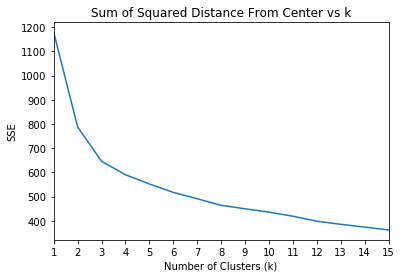

In [308]:
_=plt.plot(range(1, 16),sse)
_= plt.title("Sum of Squared Distance From Center vs k")
_= plt.xticks(range(16))
_= plt.xlim((1,15))
_= plt.xlabel("Number of Clusters (k)")
_= plt.ylabel("SSE")

In [ ]:
silhouette_score

In [ ]:
from sklearn.metrics import silhouette_score

In [337]:
from sklearn.metrics import silhouette_score

In [339]:
clusters;

In [340]:
clusters_df = pd.DataFrame(clusters, index=combined3.index)

In [349]:
clusters_df.rename({0:'clusters'}, axis=1, inplace=True) 


In [350]:
combined_with_clusters = pd.concat([combined3, clusters_df], axis=1)

In [351]:
cluster_df = combined_with_clusters[['clusters', 'number_of_likes']]

In [481]:
np.array(cluster_df[cluster_df['clusters']==0].number_of_likes).std()

71.46881152228686

In [363]:
list(combined3.columns)

['DOW_0',
 'DOW_1',
 'DOW_2',
 'DOW_3',
 'DOW_4',
 'DOW_5',
 'DOW_6',
 'hour',
 'month',
 'num_people_tagged',
 'number_of_likes',
 'faces_visible',
 'sale',
 'edited',
 'butt_pic',
 'ocean',
 'skate',
 'drift_content',
 'product_shot',
 'lifestyle',
 'in_shop',
 'pro\\model',
 'in_nature',
 'surf',
 'male',
 'female',
 'mixed_gender',
 'bikini',
 'apparel',
 'biki+apparel',
 'no_product',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 11